In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import numpy as np
from PIL import Image
import cv2
import matplotlib.image as mpimg
import os
import scipy.ndimage as ndimage
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 30

In [3]:
#importing dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2273 files belonging to 10 classes.


In [4]:
#display dataset classes
class_names = dataset.class_names
class_names

['guava_diseased',
 'guava_healthy',
 'jamun_diseased',
 'jamun_healthy',
 'lemon_diseased',
 'lemon_healthy',
 'mango_diseased',
 'mango_healthy',
 'pomegranate_diseased',
 'pomegrenate_healthy']

In [5]:
# for image_batch, labels_batch in dataset.take(1):
#     #print(image_batch.shape)
#     #print(labels_batch.numpy())
    
#     for i in range(12):
#         ax = plt.subplot(3,4,i+1)
        
#         #plt.imshow(image_batch[i].numpy().astype("uint8"))
        
#         def rgb2gray(rgb):
#             return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
        
        
#         img_gray = rgb2gray(image_batch[i])
        
#         def apply_gaussian_blur(img_gray):
#             blurred_image = tf.image.gaussian_filter2d(image, sigma=1.0)
#             return blurred_image
        
#         plt.imshow(img_gray, cmap=plt.get_cmap('gray'))
#         #plt.show()
        
#         plt.title(class_names[labels_batch[i]])
#         plt.axis("off")

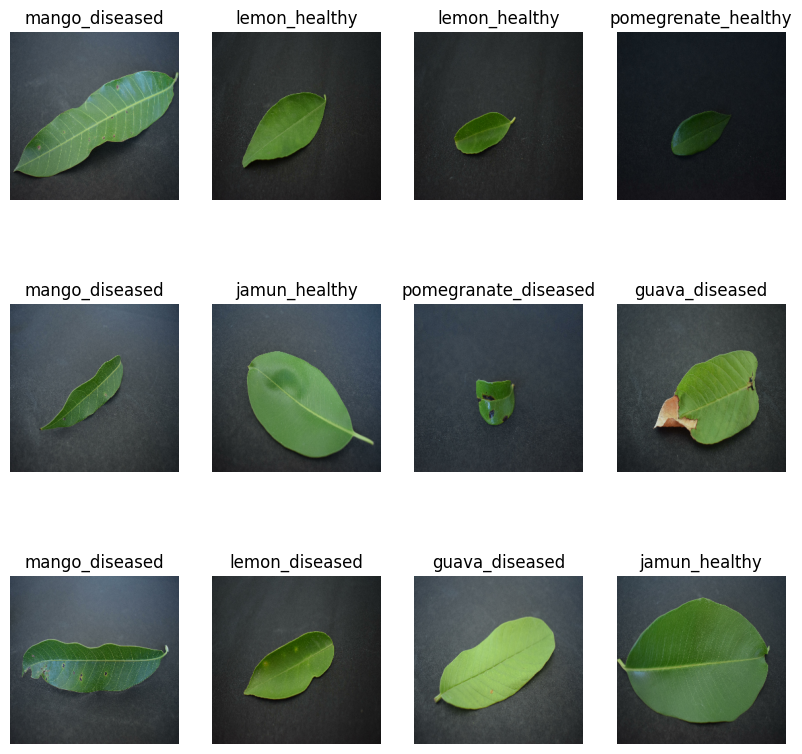

In [5]:
# Display Images

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [5]:
len(dataset)

72

In [6]:
train_size = 0.8
len(dataset)*train_size

57.6

In [7]:
train_ds = dataset.take(57)
len(train_ds)

57

In [8]:
test_ds = dataset.skip(57)
len(test_ds)

15

In [9]:
val_size=0.1
len(dataset)*val_size

7.2

In [10]:
val_ds = test_ds.take(7)
len(val_ds)

7

In [11]:
test_ds = test_ds.skip(7)
len(test_ds)

8

In [12]:
#dataset partition

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(dataset)

72

In [15]:
len(train_ds)

57

In [16]:
len(val_ds)

7

In [17]:
len(test_ds)

8

In [18]:
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
#image resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [20]:
#data augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

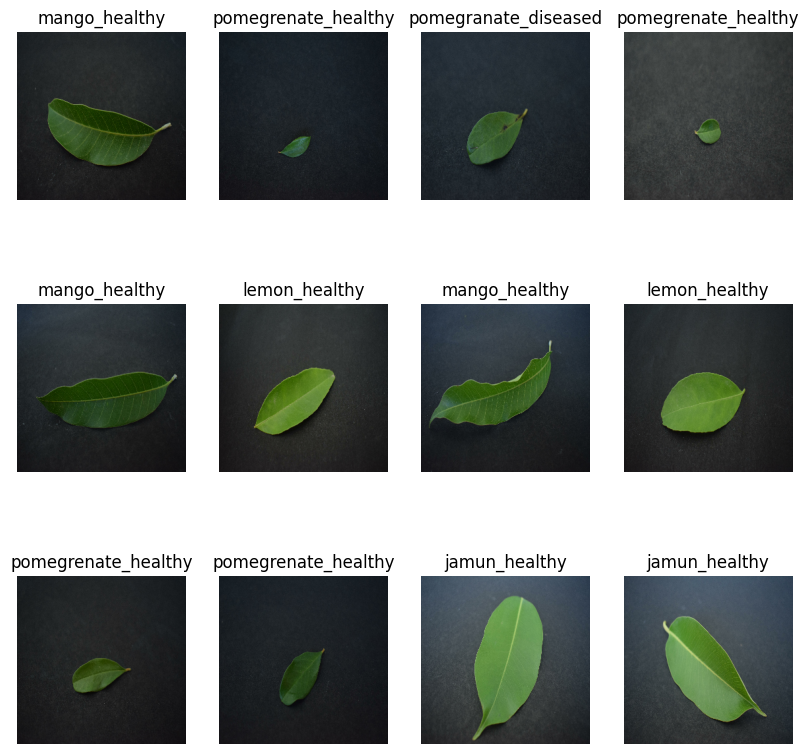

In [21]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [21]:
#Applying data augmentation to the dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

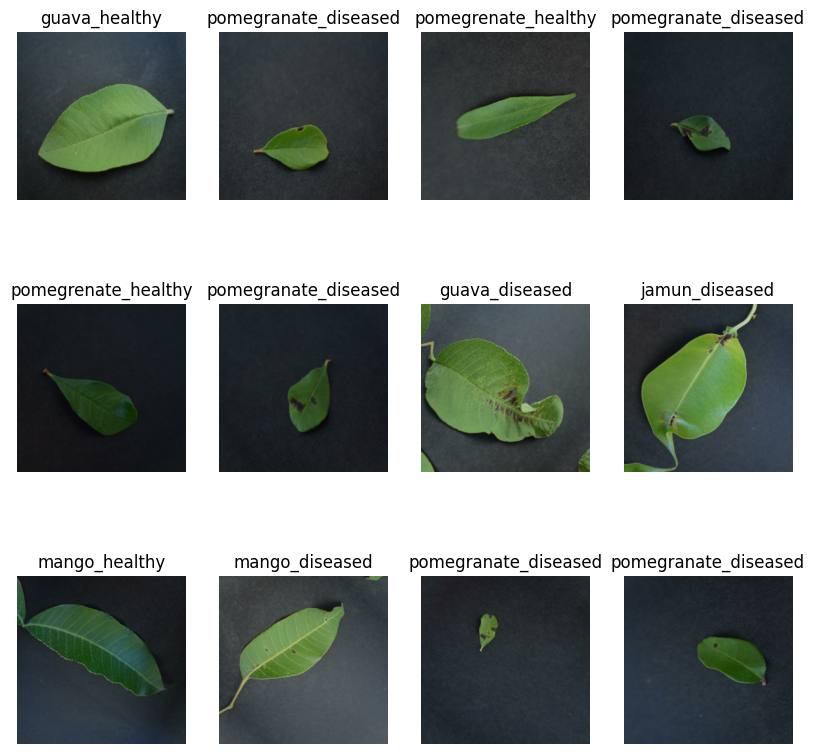

In [25]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [22]:
len(train_ds)

57

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (32, 123008)             

In [25]:
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
57/57 [==============================] - 125s 1s/step - loss: 2.2450 - accuracy: 0.2226 - val_loss: 1.7485 - val_accuracy: 0.3080
Epoch 2/30
57/57 [==============================] - 41s 722ms/step - loss: 1.4860 - accuracy: 0.4468 - val_loss: 1.1319 - val_accuracy: 0.6250
Epoch 3/30
57/57 [==============================] - 40s 704ms/step - loss: 1.1001 - accuracy: 0.5833 - val_loss: 0.9122 - val_accuracy: 0.6741
Epoch 4/30
57/57 [==============================] - 40s 701ms/step - loss: 0.9016 - accuracy: 0.6782 - val_loss: 0.8105 - val_accuracy: 0.7009
Epoch 5/30
57/57 [==============================] - 39s 685ms/step - loss: 0.7734 - accuracy: 0.7072 - val_loss: 0.7180 - val_accuracy: 0.7232
Epoch 6/30
57/57 [==============================] - 39s 685ms/step - loss: 0.7948 - accuracy: 0.7018 - val_loss: 0.8333 - val_accuracy: 0.6429
Epoch 7/30
57/57 [==============================] - 39s 685ms/step - loss: 0.6593 - accuracy: 0.7643 - val_loss: 0.9059 - val_accuracy: 0.6250
E

In [27]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 28s 159ms/step - loss: 0.3324 - accuracy: 0.8750


In [28]:
scores2 = model.evaluate(train_ds)

57/57 [==============================] - 18s 308ms/step - loss: 0.3300 - accuracy: 0.8794


In [29]:
scores3 = model.evaluate(val_ds)

7/7 [==============================] - 1s 155ms/step - loss: 0.3714 - accuracy: 0.8750


In [30]:
score4 = model.evaluate(dataset)

72/72 [==============================] - 34s 425ms/step - loss: 0.3499 - accuracy: 0.8759


In [31]:
scores

[0.33241507411003113, 0.875]

In [32]:
scores2

[0.3299800157546997, 0.8793859481811523]

In [33]:
scores3

[0.37139177322387695, 0.875]

In [34]:
score4

[0.34990593791007996, 0.875934898853302]

In [35]:
history

In [36]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 57}

In [37]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
type(history.history['loss'])

list

In [39]:
len(history.history['loss'])

30

In [40]:
history.history['loss'][:5]

[2.244959592819214,
 1.4859554767608643,
 1.1000874042510986,
 0.9016305208206177,
 0.7733579874038696]

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

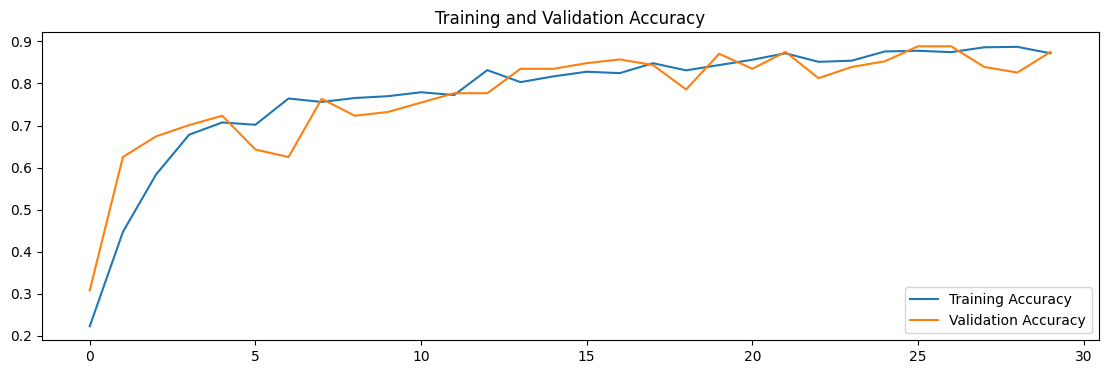

In [42]:
plt.figure(figsize=(30, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

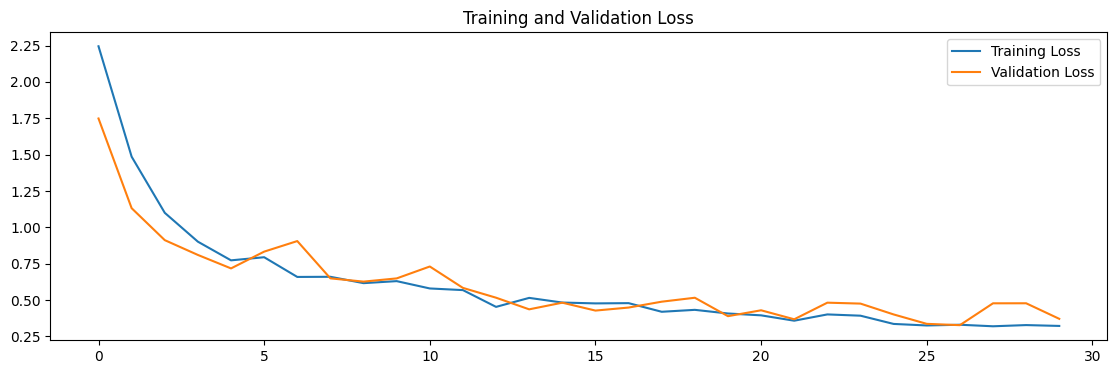

In [43]:
plt.figure(figsize=(30, 4))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: lemon_healthy
1/1 [==============================] - 0s 224ms/step
predicted label: lemon_healthy


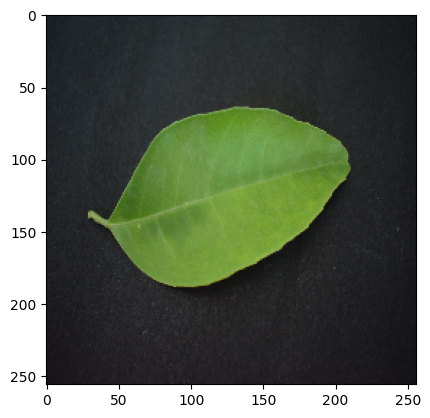

In [112]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [64]:
#Test - Accuracy curve for particular class


# class_index = 5  # Index of the desired class
# class_accuracy = history.history['accuracy'][class_index]



# epochs = EPOCHS

# plt.plot(epochs, class_accuracy, label='Class Accuracy')
# plt.title('Accuracy Curve - Class {}'.format(class_index))
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 25ms/step


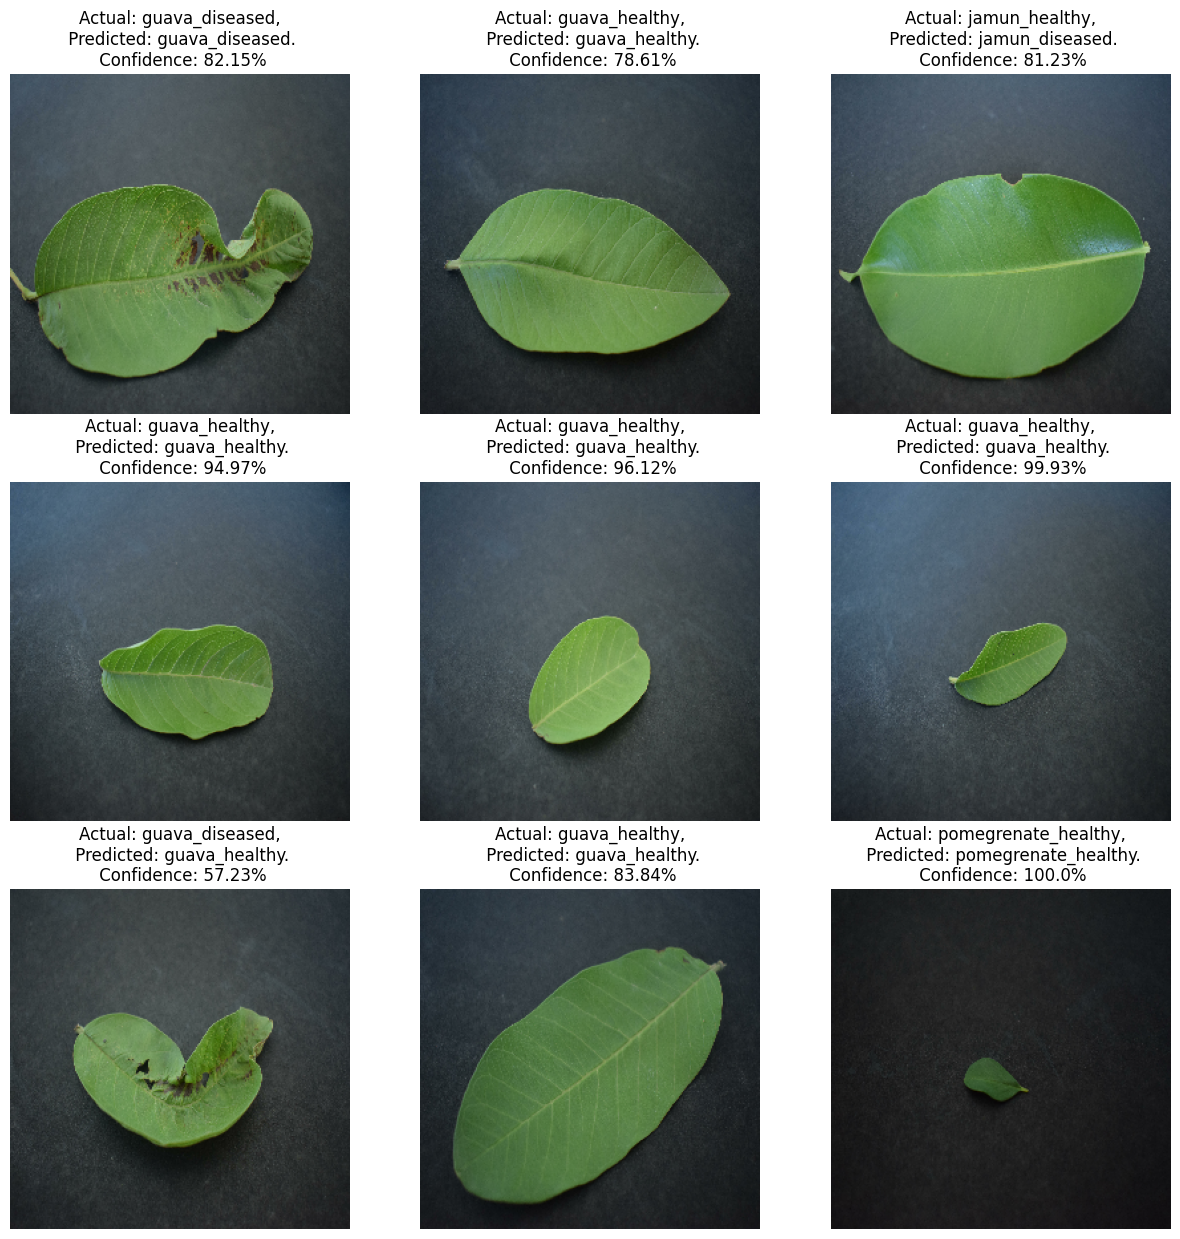

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [46]:
y_pred_prob = model.predict(test_ds)

8/8 [==============================] - 1s 150ms/step


In [47]:
print(y_pred_prob)

[[8.21540177e-01 1.40039194e-02 2.37213802e-02 ... 1.43085357e-08
  3.99635125e-09 7.87350452e-09]
 [3.24240391e-05 7.86079347e-01 2.01082826e-01 ... 1.35749602e-07
  1.40145909e-10 7.16957994e-15]
 [2.34514242e-04 1.41126034e-03 8.12305927e-01 ... 1.77934947e-08
  1.28929864e-12 8.77897134e-15]
 ...
 [5.43019087e-06 3.20711583e-02 7.42077816e-07 ... 7.76358619e-02
  8.87958765e-01 2.32544914e-03]
 [1.37233045e-02 1.65344530e-03 5.54896379e-03 ... 1.02307413e-05
  1.07252481e-06 4.99600856e-06]
 [1.01537665e-03 5.59716579e-03 9.93025422e-01 ... 8.55500363e-14
  3.92616452e-12 6.64819114e-16]]


In [48]:
y_pred_labels = np.argmax(y_pred_prob, axis=1)

In [49]:
print(y_pred_labels)

[0 1 2 1 1 1 1 1 9 6 2 2 9 1 2 4 8 2 2 6 7 5 2 4 8 9 1 7 1 6 6 1 2 6 5 2 7
 0 2 2 7 9 2 2 6 1 6 2 9 1 1 9 2 2 5 6 9 1 1 5 1 8 0 0 4 1 2 6 2 8 2 9 9 5
 2 5 7 5 7 1 7 6 1 5 7 8 8 6 3 9 3 2 2 3 6 3 6 4 9 8 1 2 2 5 3 2 1 9 6 1 2
 7 9 9 6 3 5 2 8 6 9 7 9 2 2 8 2 5 5 6 2 2 3 6 6 3 0 0 2 9 2 8 9 1 1 8 1 8
 8 2 6 8 2 1 5 0 3 6 1 7 5 9 1 9 6 1 2 7 5 1 1 8 2 7 3 0 4 8 2 1 2 3 2 2 8
 1 8 4 8 9 2 4 8 3 2 8 5 9 1 6 6 7 7 5 2 2 2 3 1 0 2 7 0 2 2 3 6 7 9 3 9 9
 2 4 1 1 5 2 3 8 9 7 6 2 9 1 6 3 6 1 8 1 6 2 1 9 2 9 1 6 2 6 4 8 6 2]


In [50]:
y_true_labels = np.concatenate([y for x, y in test_ds], axis=0)

In [51]:
print(y_true_labels)

[6 2 9 8 1 2 2 5 3 2 1 9 0 1 2 7 9 9 6 2 5 2 8 6 9 7 9 2 2 8 3 5 5 9 1 9 6
 1 2 7 5 0 0 8 0 7 3 0 4 8 3 1 1 3 2 2 8 2 8 4 8 9 2 4 8 3 5 8 5 9 1 6 6 7
 7 5 2 2 3 3 1 0 2 7 0 3 2 3 6 7 9 3 9 9 2 4 4 1 2 6 2 8 2 9 9 5 2 5 7 5 7
 0 7 6 1 5 7 8 8 6 3 9 3 2 2 3 6 3 1 1 5 2 3 8 9 7 6 2 9 1 6 3 6 1 8 1 6 2
 1 9 2 9 0 6 3 6 5 8 6 2 5 6 2 2 3 6 6 3 0 0 3 9 2 8 9 3 7 8 0 8 8 0 6 8 2
 1 5 0 3 6 1 7 3 6 5 3 7 0 2 3 7 9 2 2 6 1 6 2 9 1 3 9 2 3 5 6 9 1 1 5 1 8
 0 0 0 1 3 1 1 1 0 1 9 6 2 2 9 0 2 4 6 2 3 6 7 5 2 4 8 9 1 7 1 6 6 1]


In [52]:
cm = confusion_matrix(y_true_labels, y_pred_labels)

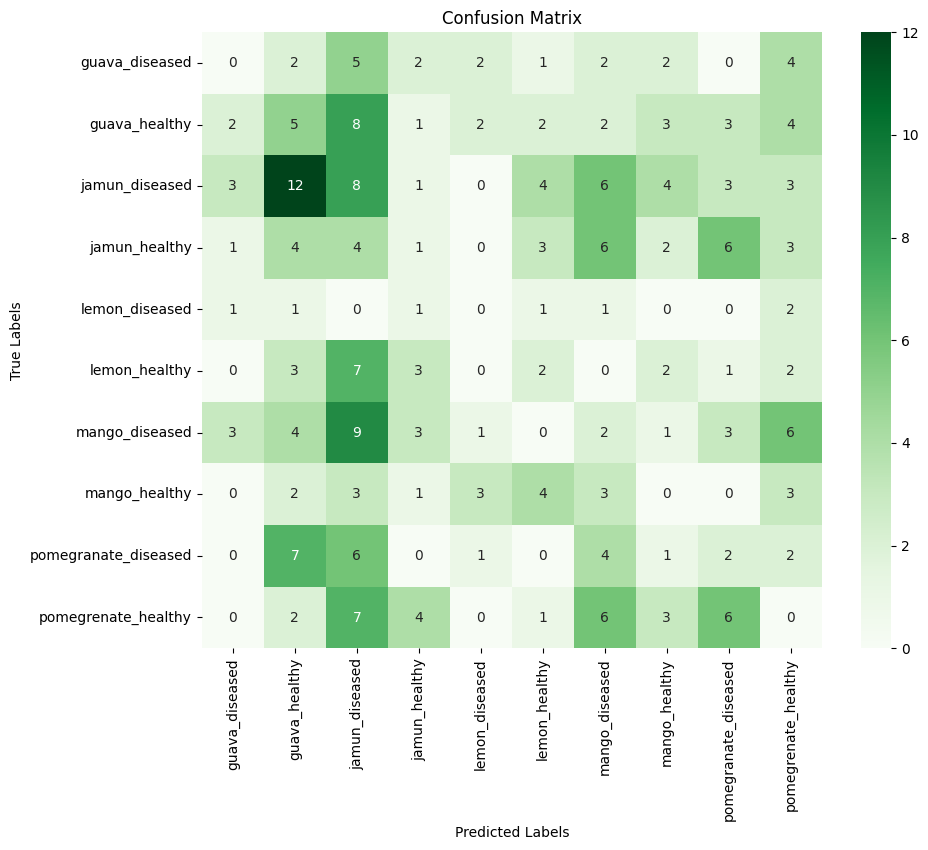

In [57]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Greens", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [115]:
# data = tf.data.Dataset.from_tensor_slices((images, labels))
for image, labels in test_ds:
    arr = labels.numpy()
    arr_expanded = np.expand_dims(arr, axis=0)
    arr2 = np.concatenate(arr_expanded, axis = 0)
    print(arr2)

[5 7 2 0 8 5 7 4 1 8 1 6 6 6 0 9 4 1 8 2 2 1 3 5 3 9 7 6 3 5 3 3]
[3 2 3 7 0 9 1 8 1 1 2 2 1 0 6 1 9 5 6 7 1 3 2 2 7 9 5 9 9 3 9 9]
[8 9 1 7 8 6 9 2 8 7 1 5 6 6 6 3 2 2 2 3 5 0 1 5 3 0 1 9 3 1 8 8]
[5 3 2 1 8 8 3 3 6 1 2 7 0 6 2 2 1 1 4 6 3 2 3 3 0 6 7 1 3 3 5 3]
[9 0 2 2 5 7 2 3 2 4 3 3 2 4 2 6 8 8 4 3 9 2 4 9 2 4 6 8 9 9 3 2]
[2 2 2 4 6 5 5 6 6 1 2 1 1 1 6 9 5 9 6 8 1 6 8 3 3 0 0 2 2 2 0 6]
[6 1 2 3 7 6 0 6 7 1 8 9 1 9 1 2 7 5 0 0 1 6 2 9 3 1 5 6 8 3 8 3]
[3]


In [116]:
plabel = labels.numpy()
print(plabel)

[3]


In [117]:
predicted_probabilities = model.predict(test_ds)
print(predicted_probabilities)

8/8 [==============================] - 1s 130ms/step
[[6.8898307e-06 1.1908127e-02 7.3513645e-04 ... 2.3659992e-03
  5.5516102e-06 3.5501675e-12]
 [8.5496334e-14 1.1185771e-11 3.5484984e-10 ... 9.9999487e-01
  6.1729783e-15 8.9845530e-13]
 [1.3627467e-04 3.8923935e-03 6.2524283e-01 ... 2.4873841e-06
  5.8421901e-10 5.3864802e-11]
 ...
 [1.1526009e-05 4.2928813e-04 4.5154218e-05 ... 2.9311056e-04
  9.9778467e-01 5.6668714e-04]
 [2.2112286e-05 1.1723476e-04 7.6759271e-02 ... 2.7582233e-04
  2.5695124e-08 2.6183564e-09]
 [2.3043726e-04 3.5189551e-03 1.3410174e-02 ... 8.3206961e-04
  6.5307895e-06 1.2627146e-08]]


In [118]:
predicted_labels = np.argmax(predicted_probabilities, axis=1)
print(predicted_labels)

[5 7 2 6 8 5 7 4 1 9 1 6 6 6 0 9 5 1 8 2 3 1 3 5 2 9 7 6 3 5 3 3 3 2 3 7 0
 9 1 8 1 1 2 6 1 2 6 1 9 5 6 7 1 2 2 2 7 9 5 9 9 3 9 9 8 9 1 7 8 6 9 2 8 7
 1 5 6 6 6 2 2 2 2 3 5 0 1 5 3 0 1 9 3 1 8 8 5 3 2 7 8 8 3 2 6 1 0 7 3 6 3
 2 1 1 5 6 3 1 2 3 2 6 7 1 2 3 5 3 9 0 2 2 5 7 2 3 2 2 3 3 2 5 2 6 8 8 4 3
 9 2 7 9 2 5 6 8 9 9 1 3 2 2 2 4 6 5 5 6 6 1 2 1 1 1 6 9 5 9 6 8 1 6 8 3 3
 0 0 2 3 2 2 6 6 1 2 2 7 6 0 6 7 1 8 9 1 9 1 2 7 5 0 0 1 6 2 9 2 1 5 6 8 3
 8 3 3]
